In [2]:
%matplotlib inline
import csv as csv
import numpy as np

csv_file = csv.reader(open('train.csv','r'))
header = next(csv_file) # Skip first line
data = []
for row in csv_file:
    data.append(row)
data = np.array(data)

In [3]:
data

array([['1', '0', '3', ..., '7.25', '', 'S'],
       ['2', '1', '1', ..., '71.2833', 'C85', 'C'],
       ['3', '1', '3', ..., '7.925', '', 'S'],
       ..., 
       ['889', '0', '3', ..., '23.45', '', 'S'],
       ['890', '1', '1', ..., '30', 'C148', 'C'],
       ['891', '0', '3', ..., '7.75', '', 'Q']], 
      dtype='<U82')

In [4]:
data[0]

array(['1', '0', '3', 'Braund, Mr. Owen Harris', 'male', '22', '1', '0',
       'A/5 21171', '7.25', '', 'S'], 
      dtype='<U82')

In [5]:
data[-1]

array(['891', '0', '3', 'Dooley, Mr. Patrick', 'male', '32', '0', '0',
       '370376', '7.75', '', 'Q'], 
      dtype='<U82')

In [6]:
#data[0:,4] == data[0::,4]
#data[0:,4] == data[:,4]

In [7]:
n_passengers = np.size(data[:,1])
n_survived = np.sum(data[:,1].astype(np.float))
propn_survivors = n_survived / n_passengers
propn_survivors

0.38383838383838381

In [8]:
women = data[:,4] == 'female'
men = data[:,4] == 'male'
rows_women = data[women,1].astype(np.int)
rows_men = data[men,1].astype(np.int)

propn_women_survived = np.sum(rows_women) / np.size(rows_women)
propn_men_survived = np.sum(rows_men) / np.size(rows_men)

In [9]:
print(propn_men_survived)
print(propn_women_survived)

0.188908145581
0.742038216561


In [10]:
test_file = open('test.csv')
test_file_reader = csv.reader(test_file)
header = next(test_file_reader)

predn_file = open('genderbasedmodel.csv','w', encoding='UTF-8')
predn_file_writer = csv.writer(predn_file)

In [11]:
print(header)
predn_file_writer.writerow(['PassengerId','Survived'])
for row in test_file_reader:
    if row[3] == 'female':
        predn_file_writer.writerow([row[0],1])
    else:
        predn_file_writer.writerow([row[0],0])

test_file.close()
predn_file.close()

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


Now, let's try some more complicated conditions
https://www.kaggle.com/c/titanic/details/getting-started-with-python

In [12]:
# Gender, class and ticket price. bin up ticket price into four bins
import pandas as pd
print(data[:10,-3])
print(pd.cut(data[:10,-3].astype(np.float),4,retbins=True))

['7.25' '71.2833' '7.925' '53.1' '8.05' '8.4583' '51.8625' '21.075'
 '11.1333' '30.0708']
(  (7.186, 23.258]
 (55.275, 71.283]
  (7.186, 23.258]
 (39.267, 55.275]
  (7.186, 23.258]
  (7.186, 23.258]
 (39.267, 55.275]
  (7.186, 23.258]
  (7.186, 23.258]
 (23.258, 39.267]
Levels (4): Index(['(7.186, 23.258]', '(23.258, 39.267]',
                   '(39.267, 55.275]', '(55.275, 71.283]'], dtype=object), array([  7.1859667,  23.258325 ,  39.26665  ,  55.274975 ,  71.2833   ]))


In [13]:
#binning
fare_ceiling = 40
data[ data[:,-3].astype(np.float) >= fare_ceiling, -3 ] = fare_ceiling - 1.0
fare_bracket_size = 10
n_brackets = int(fare_ceiling/fare_bracket_size)
#n_classes = 3
n_classes = len(np.unique(data[:,2]))

In [14]:
survival_table = np.zeros([2,n_classes,n_brackets])

In [15]:
for i in range(n_classes):
    for j in range(n_brackets):
        w_stats = data[
            (data[:,4] == 'female')
            & (data[:,2].astype(np.float) == i+1)
            & (data[:,-3].astype(np.float) >= j*fare_bracket_size)
            & (data[:,-3].astype(np.float) < (j+1)*fare_bracket_size)
            ,1]
        m_stats = data[
            (data[:,4] == 'male')
            & (data[:,2].astype(np.float) == i+1)
            & (data[:,-3].astype(np.float) >= j*fare_bracket_size)
            & (data[:,-3].astype(np.float) < (j+1)*fare_bracket_size)
            ,1]
        survival_table[0,i,j] = np.mean(w_stats.astype(np.float))
        survival_table[1,i,j] = np.mean(m_stats.astype(np.float))

/Users/aswinrajkumar/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [16]:
survival_table[0]

array([[        nan,         nan,  0.83333333,  0.97727273],
       [        nan,  0.91428571,  0.9       ,  1.        ],
       [ 0.59375   ,  0.58139535,  0.33333333,  0.125     ]])

In [17]:
# Fix NaN values by the below method
survival_table[ survival_table != survival_table ] = 0.
survival_table[0]

array([[ 0.        ,  0.        ,  0.83333333,  0.97727273],
       [ 0.        ,  0.91428571,  0.9       ,  1.        ],
       [ 0.59375   ,  0.58139535,  0.33333333,  0.125     ]])

In [18]:
# create a model with a cut-off probability of 0.5
survival_table[survival_table >= 0.5] = 1   #survive
survival_table[survival_table < 0.5] = 0    #will die
survival_table

array([[[ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 1.,  1.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [19]:
test_file = open('test.csv')
test_file_reader = csv.reader(test_file)
header = next(test_file_reader)
predn_file = open('genderclassmodel.csv','w')
predn_file_writer = csv.writer(predn_file)
predn_file_writer.writerow(['PassengerId','Survived'])

22

In [20]:
for row in test_file_reader:
    for j in range(n_brackets):
        try:
            row[8] = float(row[8])
        except:
            bin_fare = 3 - float(row[1])
            break
        if row[8] > fare_ceiling:
            bin_fare = n_brackets - 1
            break
        if row[8] >= j*fare_bracket_size and row[8] < (j+1)*fare_bracket_size:
            bin_fare = j
            break
    if row[3] == 'female':
        predn_file_writer.writerow([row[0],int(survival_table[0,float(row[1])-1,bin_fare])])
    else:
        predn_file_writer.writerow([row[0],int(survival_table[1,float(row[1])-1,bin_fare])])
test_file.close()
predn_file.close()

###Using Pandas
https://www.kaggle.com/c/titanic/details/getting-started-with-python-ii

In [22]:
type(data[:,5])

numpy.ndarray

In [24]:
data[:,5].astype(np.float)

ValueError: could not convert string to float: 

In [25]:
# Error above cos of missing values. Easier with pandas
df = pd.read_csv('train.csv',header=0)
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25            26         1       3   
26            27         0       3   
27            28         0       1   
28            29         1       3   
29            30         0       3   
..           ...       ...     ...   
861          862         0       2   
862          863         1       1   
863          864         0       3   
864          865         0       2   
865          866         1       2   
866          867         1       2   
867          868         0       1   
868          869         0       3   
869          870         1       3   
870          871         0       3   
871          872         1       1   
872          873         0       1   
873          874         0       3   
874          875         1       2   
875          876         1       3   
876          877         0       3   
877          878         0       3   
878          879         0       3   
879          880         1       1   
880          881         1       2   
881          882         0       3   
882          883         0       3   
883          884         0       2   
884          885         0       3   
885          886         0       3   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex  Age  SibSp  \
0                              Braund, Mr. Owen Harris    male   22      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                               Heikkinen, Miss. Laina  female   26      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                             Allen, Mr. William Henry    male   35      0   
5                                     Moran, Mr. James    male  NaN      0   
6                              McCarthy, Mr. Timothy J    male   54      0   
7                       Palsson, Master. Gosta Leonard    male    2      3   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female   27      0   
9                  Nasser, Mrs. Nicholas (Adele Achem)  female   14      1   
10                     Sandstrom, Miss. Marguerite Rut  female    4      1   
11                            Bonnell, Miss. Elizabeth  female   58      0   
12                      Saundercock, Mr. William Henry    male   20      0   
13                         Andersson, Mr. Anders Johan    male   39      1   
14                Vestrom, Miss. Hulda Amanda Adolfina  female   14      0   
15                    Hewlett, Mrs. (Mary D Kingcome)   female   55      0   
16                                Rice, Master. Eugene    male    2      4   
17                        Williams, Mr. Charles Eugene    male  NaN      0   
18   Vander Planke, Mrs. Julius (Emelia Maria Vande...  female   31      1   
19                             Masselmani, Mrs. Fatima  female  NaN      0   
20        

In [26]:
df.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

In [27]:
type(df)

pandas.core.frame.DataFrame

In [28]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)

In [30]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [31]:
df['Age'][0:10]

0    22
1    38
2    26
3    35
4    35
5   NaN
6    54
7     2
8    27
9    14
Name: Age, dtype: float64

In [32]:
df.Age[0:10]

0    22
1    38
2    26
3    35
4    35
5   NaN
6    54
7     2
8    27
9    14
Name: Age, dtype: float64

In [33]:
type(df.Age)

pandas.core.series.Series

In [34]:
df.Age.mean()

29.69911764705882

In [35]:
df.Age.median()

28.0

In [37]:
df[['Sex','Age']].head()

Sex  Age
0    male   22
1  female   38
2  female   26
3  female   35
4    male   35

In [38]:
df[df.Age > 60].head()

PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
170          171         0       1       Van der hoef, Mr. Wyckoff  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
170  61.0      0      0      111240  33.5000   B19        S

In [39]:
df[df.Age > 60].head()[['Sex','Age']]

Sex   Age
33   male  66.0
54   male  65.0
96   male  71.0
116  male  70.5
170  male  61.0

In [41]:
df[df.Age.isnull()].head()

PassengerId  Survived  Pclass                           Name     Sex  Age  \
5             6         0       3               Moran, Mr. James    male  NaN   
17           18         1       2   Williams, Mr. Charles Eugene    male  NaN   
19           20         1       3        Masselmani, Mrs. Fatima  female  NaN   
26           27         0       3        Emir, Mr. Farred Chehab    male  NaN   
28           29         1       3  O'Dwyer, Miss. Ellen "Nellie"  female  NaN   

    SibSp  Parch  Ticket     Fare Cabin Embarked  
5       0      0  330877   8.4583   NaN        Q  
17      0      0  244373  13.0000   NaN        S  
19      0      0    2649   7.2250   NaN        C  
26      0      0    2631   7.2250   NaN        C  
28      0      0  330959   7.8792   NaN        Q

In [53]:
for i in range(1,4):
    print(i, len(df[ (df.Pclass==i) & (df.Sex =='male') ]))

1 122
2 108
3 347


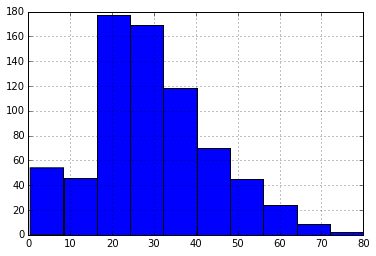

In [55]:
df.Age.hist()

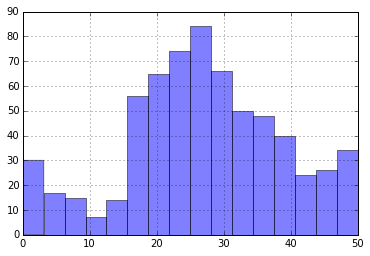

In [57]:
df.Age.hist(bins=16,range=(0,50),alpha=.5)